***Yashvir Singh***

***Semantic Segmenation on Pascal-VOC 2012 Dataset***

Importing the General Dependencies

In [2]:
import cv2 
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import PIL
import numpy as np
import keras
from albumentations import RandomRotate90
import gc
from keras import mixed_precision



2024-11-01 08:27:45.538934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 08:27:45.663443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 08:27:45.694888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 08:27:46.050671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 08:27:48.375257: W tensorflow/com

***Understanding the Images,their Masks, and the labels of the masks***

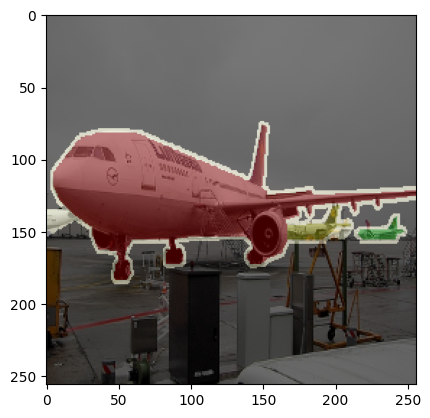

In [3]:
VOC_CLASSES = ["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair",
               "cow","diningtable","dog","horse","motorbike","person","sheep","sofa", "train", "tv/monitor"]
num_classes=len(VOC_CLASSES)
image=cv2.imread('VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg')
mask=cv2.imread('VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationObject/2007_000033.png')
image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
mask=cv2.cvtColor(mask,cv2.COLOR_RGB2BGR)
image=cv2.resize(image,(256,256))
mask=cv2.resize(mask,(256,256),interpolation=cv2.INTER_NEAREST)
image=image/255.0
plt.imshow(mask)
plt.imshow(image,alpha=0.5)
plt.show()



Getting Image IDs

In [4]:
voc_path='VOCtrainval_11-May-2012/VOCdevkit/VOC2012'
def get_data(file_path):
    with open(file_path,'r') as file:
        indices=file.read().splitlines()
    return indices
train_indices=get_data(os.path.join(voc_path,'ImageSets/Segmentation/train.txt'))
val_indices=get_data(os.path.join(voc_path,'ImageSets/Segmentation/trainval.txt'))



Experimenting with the images, by ***loading them and applying Image Augmentations***

**Note** - I am **NOT Generating** the training data here, it is just for **representation purpose**

In [5]:
import albumentations as A

def augment_image_and_mask(image, mask, augmentations):
    augmented = augmentations(image=image, mask=mask)
    return augmented['image'], augmented['mask']

def img_mask_loading_with_augmentation_with_augmentation(img_id, image_dir, mask_dir, augmentations):
    image_path = os.path.join(image_dir, f"{img_id}.jpg")
    mask_path = os.path.join(mask_dir, f"{img_id}.png")
    
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize both image and mask
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    img, mask = augment_image_and_mask(img, mask, augmentations)
    
    return img, mask

def get_augmentations():
    return A.Compose([  
        A.Resize(256, 256),  # Resize image and mask
        A.HorizontalFlip(p=0.5),  # Random horizontal flip
        A.VerticalFlip(p=0.5),  # Random vertical flip
        A.RandomRotate90(p=0.5),  # Random rotate by 90 degrees
    ])
augmentations=get_augmentations()



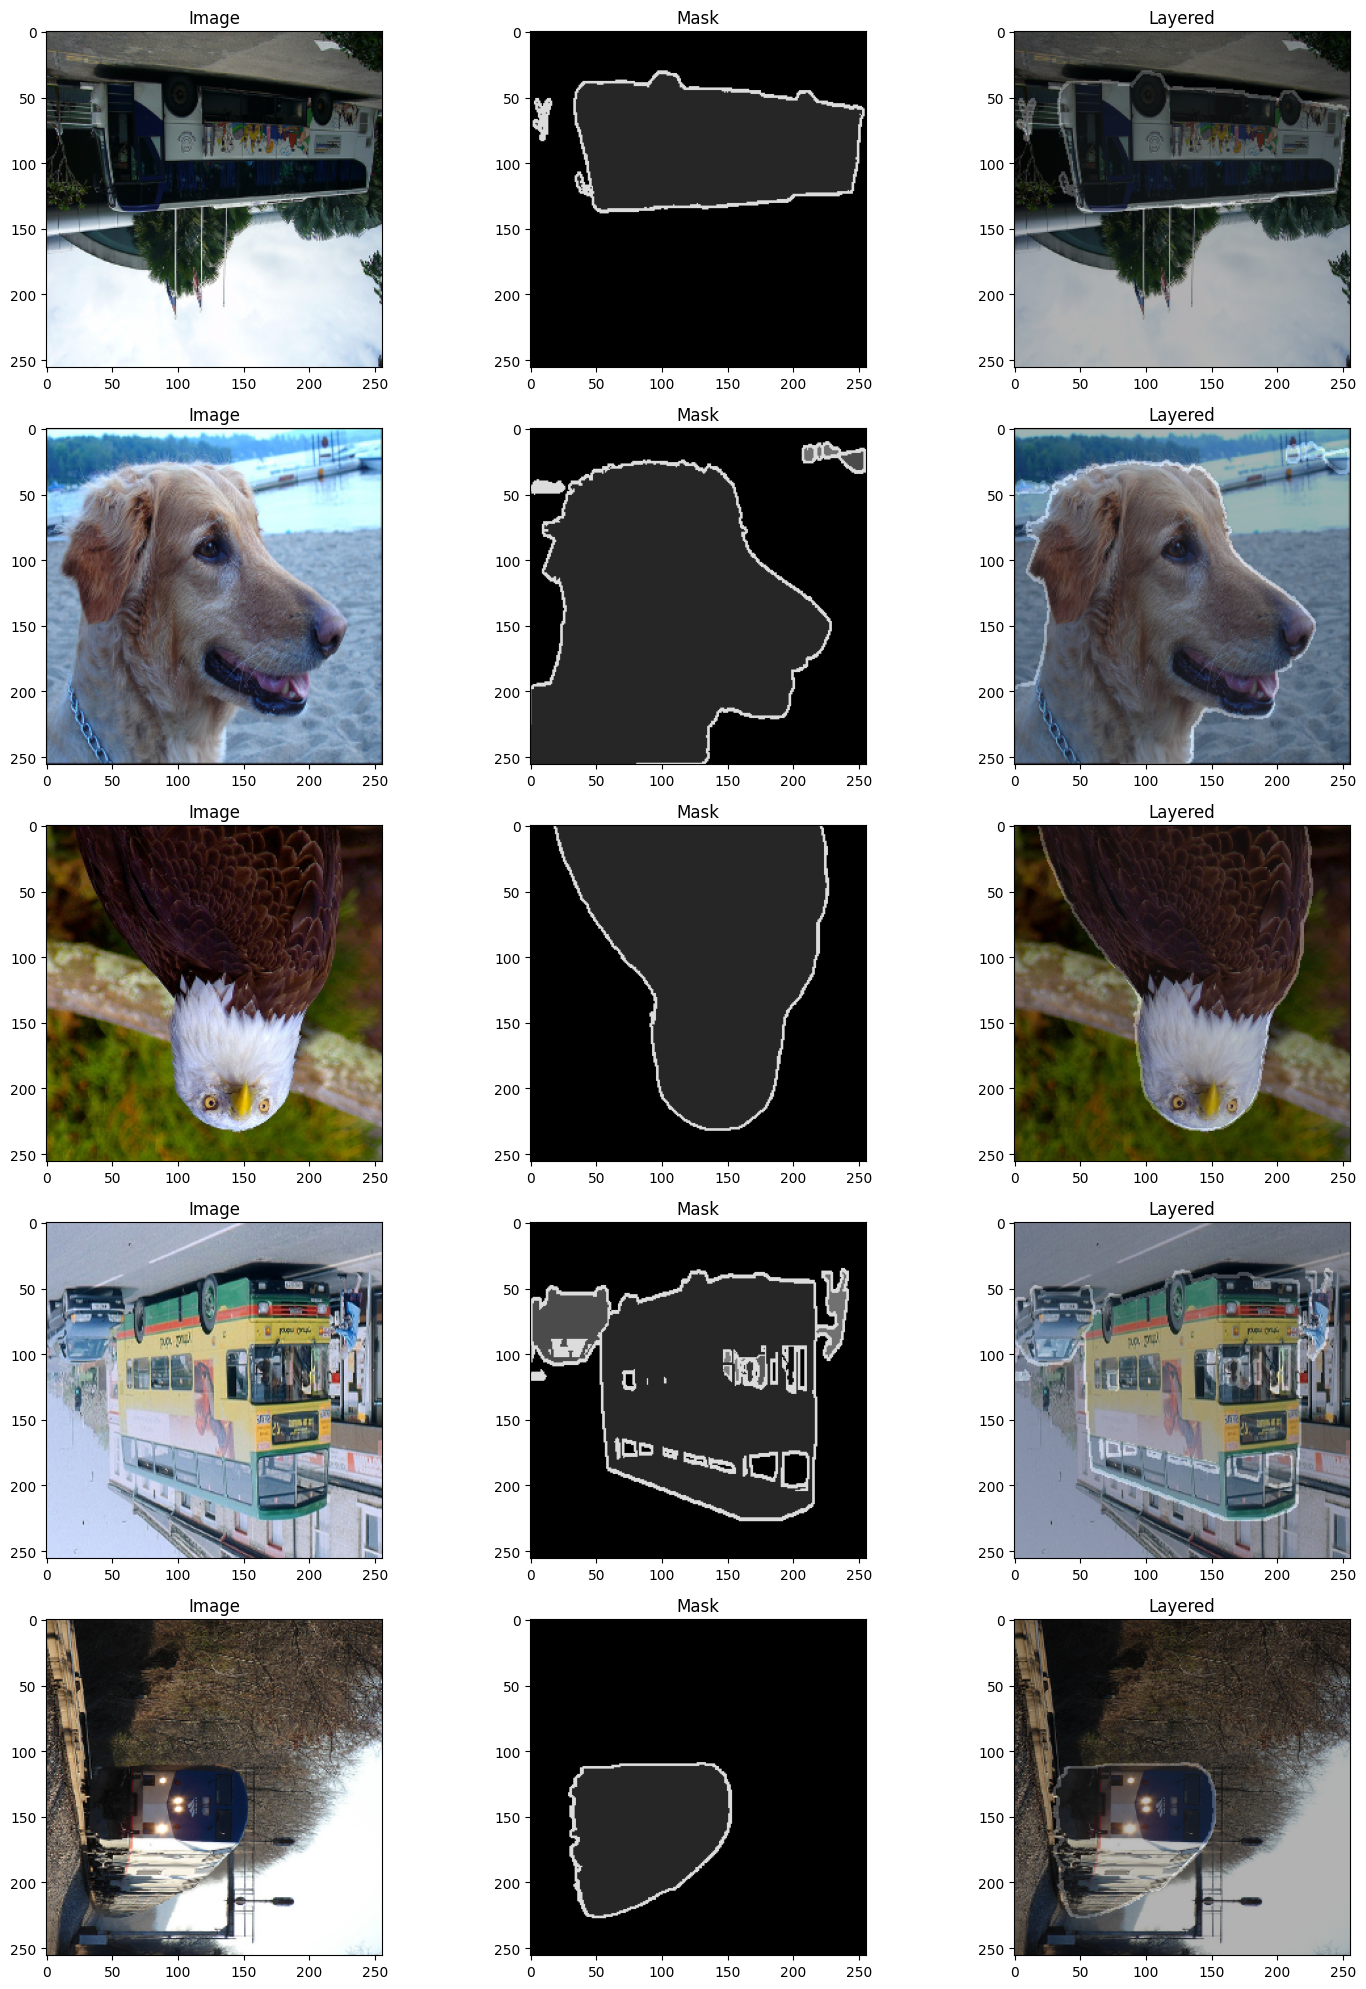

In [19]:
image_dir='VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages'
mask_dir='VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationObject'
plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(5, 3, 3 * i + 1)
    img, mask = img_mask_loading_with_augmentation_with_augmentation(train_indices[i], image_dir, mask_dir,augmentations)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.title("Image")

    plt.subplot(5, 3, 3 * i + 2)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    plt.imshow(mask)
    plt.title("Mask")

    plt.subplot(5, 3, 3 * i + 3)
    layered_img = cv2.addWeighted(img, 0.7, mask, 0.3, 0)
    plt.imshow(layered_img)
    plt.title("Layered")
plt.tight_layout()
plt.show()


***Creating a Custom Data Generator***

I could have used ImageDataGenerator using keras API. 

But for fun and better understanding, I tried making my own Data Generator

In [7]:
import albumentations as A
import numpy as np
import cv2
import tensorflow as tf
import os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_ids, image_dir, mask_dir, batch_size=2, img_size=(256, 256), augmentations=None, shuffle=True, num_classes=21, min_scale=0.5, max_scale=2.0, ignore_label=255):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.ignore_label = ignore_label
        self.on_epoch_end()

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch if enabled
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __getitem__(self, index):
        # Get a batch of image IDs
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = self.__data_generation(batch_ids)
        return images, masks

    def __data_generation(self, batch_ids):
        images = []
        masks = []

        # Load images and masks
        for img_id in batch_ids:
            img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
            mask_path = os.path.join(self.mask_dir, f"{img_id}.png")

            # Read image and mask
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Apply random scaling
            scale_factor = np.random.uniform(self.min_scale, self.max_scale)
            img = self.resize_with_scale(img, scale_factor)
            mask = self.resize_with_scale(mask, scale_factor, is_mask=True)

            # Randomly crop and pad image and mask
            img, mask = self.random_crop_and_pad(img, mask)

            # Apply augmentations (optional)
            if self.augmentations:
                augmented = self.augmentations(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # Randomly flip the image and mask
            if np.random.rand() < 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)

            # Normalize images
            img = img / 255.0

            # Ensure mask values are within the valid range
            mask[mask >= self.num_classes] = self.num_classes - 1

            # Convert mask to one-hot encoding
            one_hot_mask = tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

            images.append(img)
            masks.append(one_hot_mask)

        return np.array(images), np.array(masks)

    def resize_with_scale(self, image, scale, is_mask=False):
        """Resizes image or mask with scaling factor."""
        height, width = image.shape[:2]
        new_size = (int(width * scale), int(height * scale))
        if is_mask:
            return cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
        else:
            return cv2.resize(image, new_size)

    def random_crop_and_pad(self, img, mask):
        """Randomly crops and pads the image and mask to the target size."""
        img_height, img_width = img.shape[:2]
        target_height, target_width = self.img_size

        # Pad if necessary
        if img_height < target_height or img_width < target_width:
            pad_height = max(target_height - img_height, 0)
            pad_width = max(target_width - img_width, 0)

            img = cv2.copyMakeBorder(img, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)
            mask = cv2.copyMakeBorder(mask, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=self.ignore_label)

        # Random crop
        start_x = np.random.randint(0, img.shape[1] - target_width + 1)
        start_y = np.random.randint(0, img.shape[0] - target_height + 1)

        img = img[start_y:start_y + target_height, start_x:start_x + target_width]
        mask = mask[start_y:start_y + target_height, start_x:start_x + target_width]

        return img, mask
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5)
])

***Getting the Training and Validation Data using custom Data Generator***

In [8]:
augmentations = get_augmentations()

train_generator = DataGenerator(
    image_ids=train_indices,
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=32,
    img_size=(256, 256),
    augmentations=augmentations,
    shuffle=True
)

val_generator = DataGenerator(
    image_ids=val_indices,
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=32,
    img_size=(256, 256),
)


In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"


***Creating a model using U-Net like Structure with DenseNet121***

I initialized the model by using **DenseNet121** as backbone without the Top layer. The backbone's layers are frozen to retain their pretrained capabilities, reducing the computational load and using the learned features for pixel-level classification.

To utilize different levels of spatial detail, I extracted feature maps from three layers in the DenseNet121 model:

--**conv3_block12_concat**: Low- to mid-level features, capturing finer spatial details and textures.

--**conv4_block24_concat**: Mid-level features, providing more contextual information

--**conv5_block16_concat**: High-level features, capturing semantic information about objects.

The decoder path progressively upsamples the feature maps back to the original input size using the **Conv2D layers** and **UpSampling2D**.

The output layer uses a Conv2D layer with a (1, 1) kernel and softmax activation, producing a (256, 256, 21) output.


The final model is defined with the inputs from DenseNet121 and outputs the segmentation map, completing the U-Net-like architecture with DenseNet121 as the encoder and a custom upsampling decoder.






In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
mixed_precision.set_global_policy('mixed_float16')

def create_segmentation_model(input_shape=(256, 256, 3), num_classes=21):
    # Load DenseNet121 as the backbone
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model (optional)
    for layer in base_model.layers:
        layer.trainable = False

    # Extract feature maps from different levels
    block_3_output = base_model.get_layer("conv3_block12_concat").output  # mid-level feature
    block_4_output = base_model.get_layer("conv4_block24_concat").output  # high-level feature
    block_5_output = base_model.get_layer("conv5_block16_concat").output  # final feature map

    # Upsampling decoder
    x = layers.Conv2D(256, (3, 3), padding="same")(block_5_output)
    x = layers.UpSampling2D(size=(2, 2))(x)  # 2x upsampling
    x = layers.Concatenate()([x, block_4_output])
    
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)  # 2x upsampling
    x = layers.Concatenate()([x, block_3_output])
    
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)  # 2x upsampling
    
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)  # 2x upsampling
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)  
    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)  # Use 'softmax' for multi-class segmentation

    # Define the model
    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model


# Instantiate model
model = create_segmentation_model(input_shape=(256, 256, 3), num_classes=21)



In [34]:
root_dir = os.path.join(os.curdir,"my_logs")

def get_path():
    import time
    id_ = time.strftime("run_%Y_%m_%D_%H_%M_%S")
    return os.path.join(root_dir,id_)

board_log_path = get_path()


---------------------
**Adding the callbacks to be used during training.**

The metric that i used is **Mean Intersection-Over-Union (MeanIOU)**, a commonly used metric for segmenation tasks.

I also tried to using **ReduceLROnPlateau**, which **reduces the learning rate** once the metrics stops improving. 


In [36]:

EarlyStop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
checkpoint_path = os.path.join(os.curdir,"checkpoint.keras")
Checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')

Tensorboard = tf.keras.callbacks.TensorBoard(board_log_path)
rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=5, verbose=1, mode="max", min_lr=0.0001)

MeanIou = tf.keras.metrics.MeanIoU(num_classes=21)



-----------------------------
***Compiling the model***

For *optimizer*, I chose **Adam** for its faster convergence and its ability to handle sparse gradients effectively

I used **Categorical Cross Entropy** as *loss function*, because it works well with softmax output, and aligns with muliclass nature of segmentation 

In [40]:
tf.keras.backend.clear_session()
model.compile(optimizer='Adam'
                   ,loss='categorical_crossentropy'
                   ,metrics=[MeanIou])


In [38]:
print(model.output_shape)


(None, 256, 256, 21)


The most time-consuming task, that tests our patience to the breaking point is here. **"Training"**

I used only 5 epochs, because the memory exhausted several times during training. Fortunately, the performance is still suprisingly good. 

In [41]:

history = model.fit(train_generator,validation_data=val_generator,epochs=5,callbacks=[EarlyStop,Checkpoint,Tensorboard,rl])


Epoch 1/5


2024-10-20 07:15:15.817012: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,128,128,32]{3,2,1,0}, f16[32,128,128,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-20 07:15:16.916848: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.099944337s
Trying algorithm eng0{} for conv (f16[32,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,128,128,32]{3,2,1,0}, f16[32,128,128,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on

45/45 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - loss: 3.0967 - mean_io_u_1: 0.3061 - val_loss: 0.5101 - val_mean_io_u_1: 0.2825 - learning_rate: 0.0010
Epoch 2/5


/home/yashvir/tf/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_mean_io_u` which is not available. Available metrics are: loss,mean_io_u_1,val_loss,val_mean_io_u_1,learning_rate.
  callback.on_epoch_end(epoch, logs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - loss: 0.5673 - mean_io_u_1: 0.2647 - val_loss: 0.4491 - val_mean_io_u_1: 0.2507 - learning_rate: 0.0010
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - loss: 0.4734 - mean_io_u_1: 0.2643 - val_loss: 0.4328 - val_mean_io_u_1: 0.2501 - learning_rate: 0.0010
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 0.4673 - mean_io_u_1: 0.2643 - val_loss: 0.4123 - val_mean_io_u_1: 0.2500 - learning_rate: 0.0010
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - loss: 0.4521 - mean_io_u_1: 0.2650 - val_loss: 0.4106 - val_mean_io_u_1: 0.2521 - learning_rate: 0.0010


The *val_loss* is really less,0.4106, which is a *good thing*.

The *val_mean_io_u* is also really less, 0.2521, which is *not relieving*.  

But lets not draw conclusions without comparing the actual and predicted masks. And that is our next task.

----------------------------

***Predicting the masks for the test images***

In [45]:
test_indices = get_data(os.path.join(voc_path, 'ImageSets/Segmentation/val.txt'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


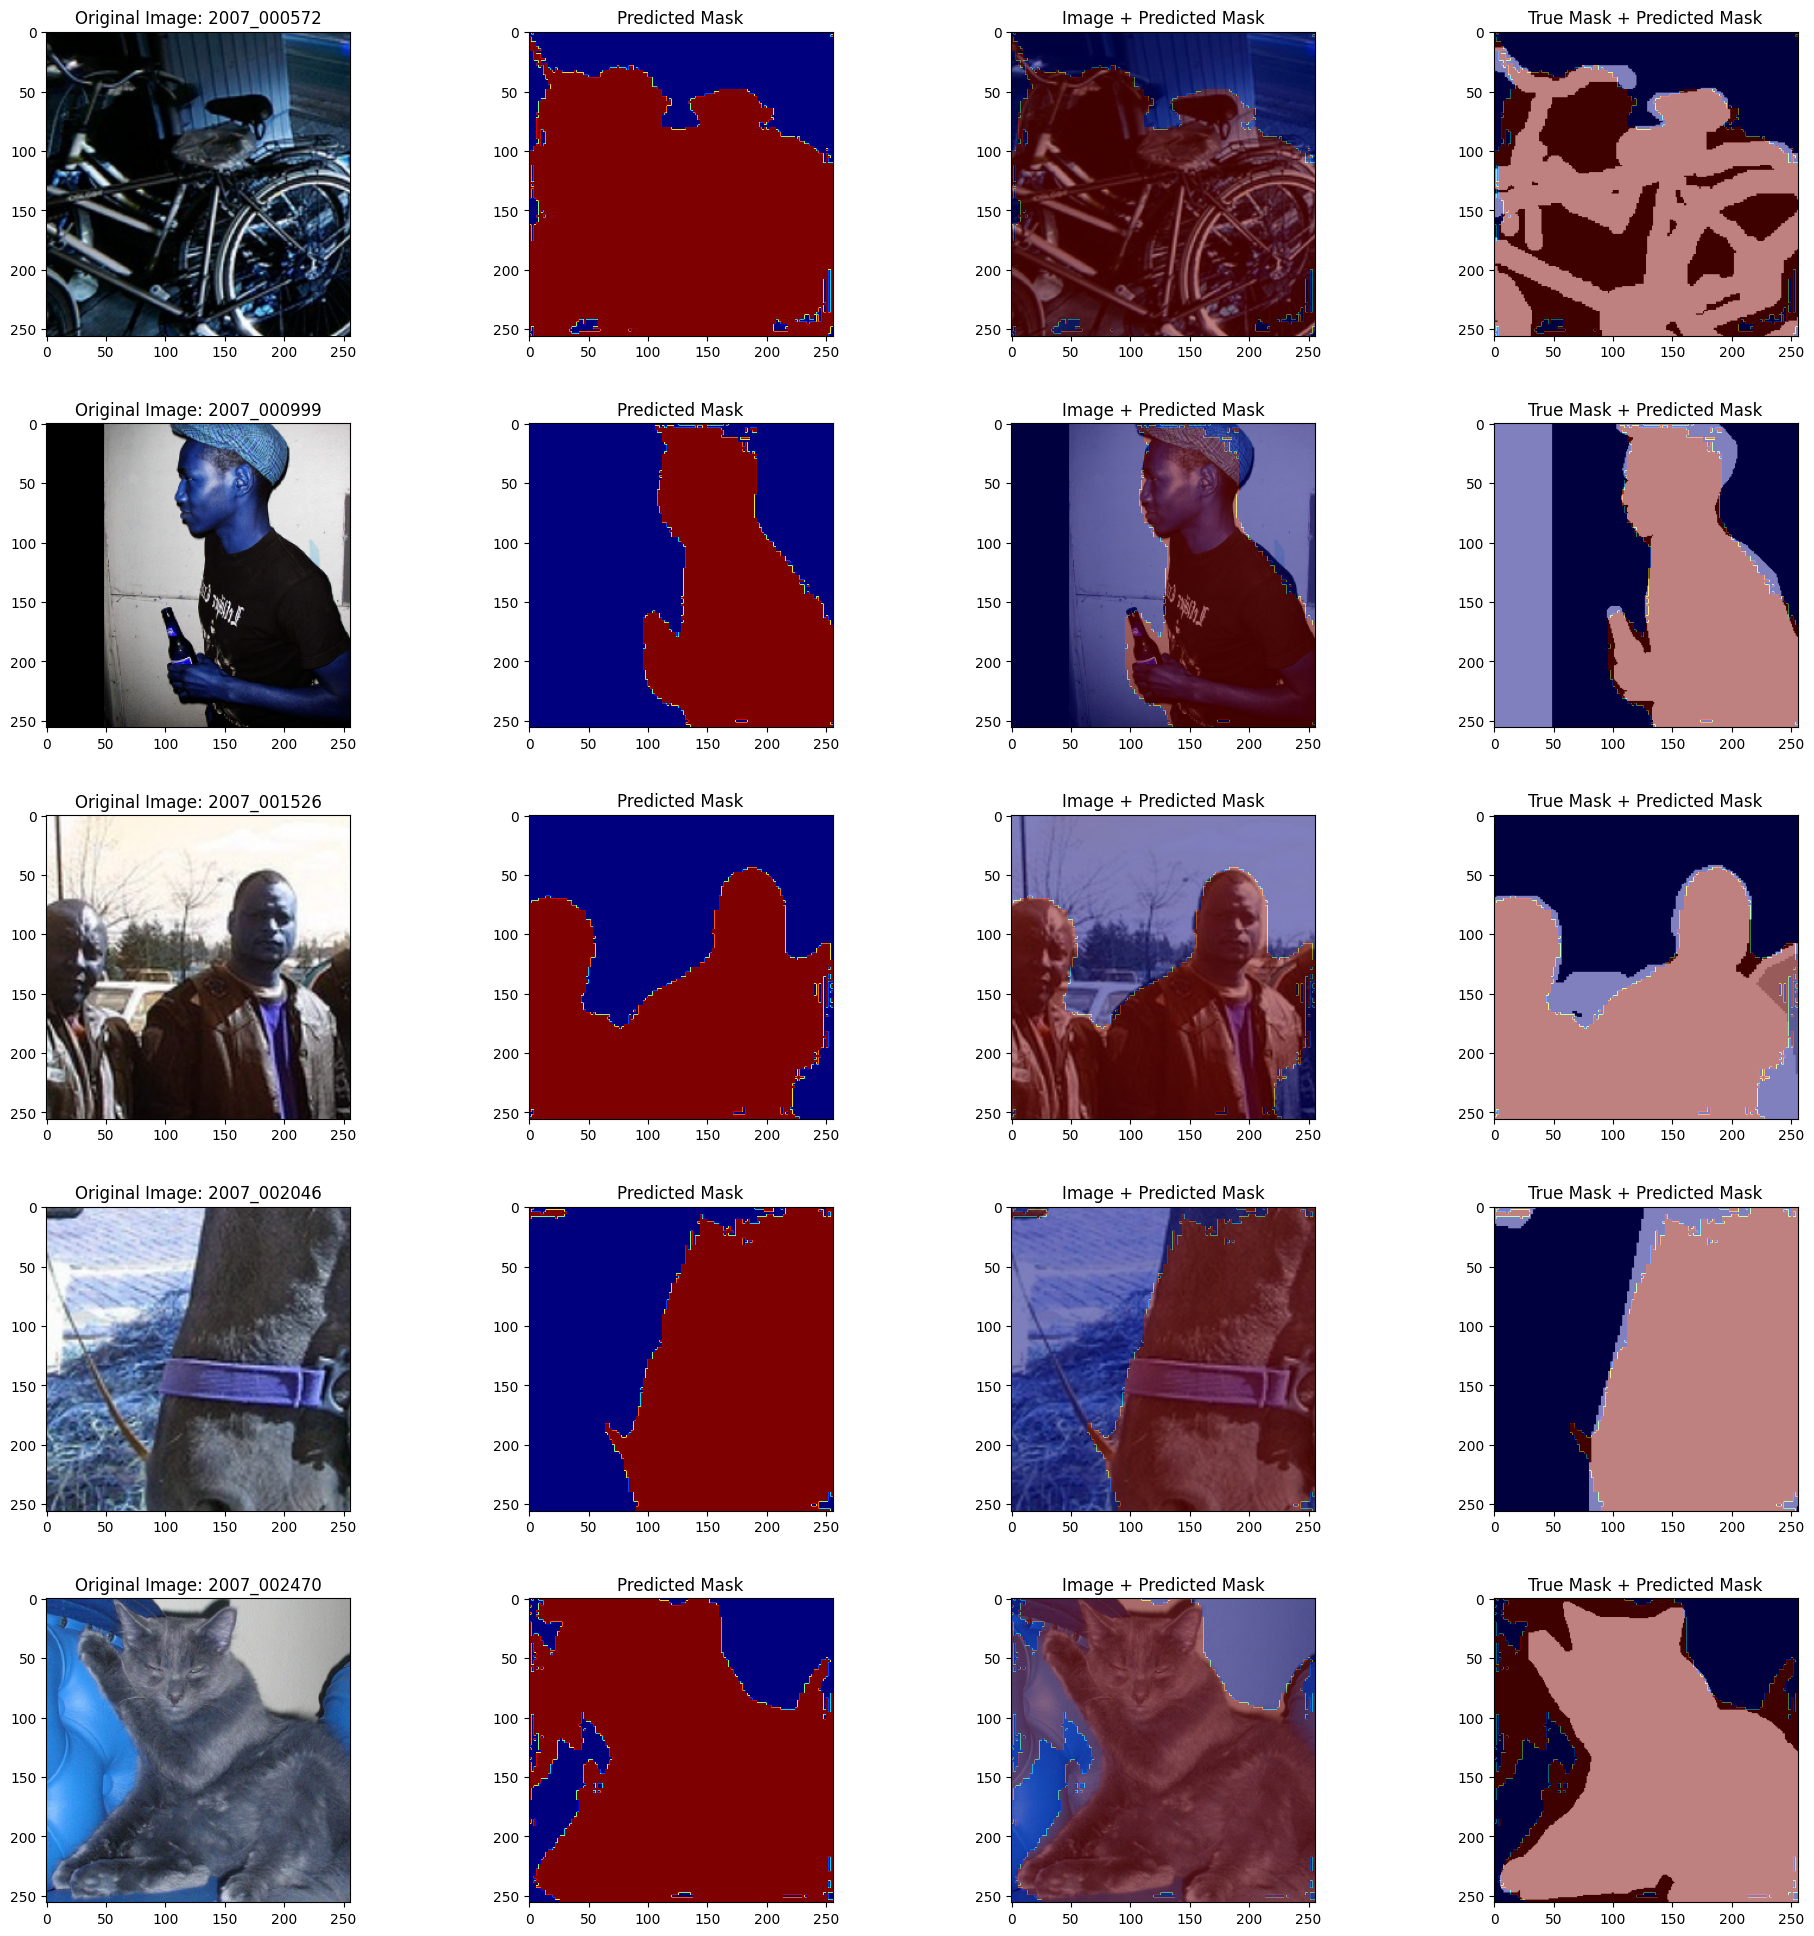

In [48]:
model = tf.keras.models.load_model("checkpoint.keras", custom_objects={"MeanIou": MeanIou})


def predict_and_visualize(model,test_generator):
    plt.figure(figsize=(20, 20))  

    for i in range(5): 
        img_batch, true_masks_batch = test_generator[i]  
        
        pred_masks = model.predict(img_batch)
        
        for j in range(len(img_batch)):
            img = img_batch[j]
            true_mask = true_masks_batch[j]  
            pred_mask_class = np.argmax(pred_masks[j], axis=-1).reshape(256, 256)  

            # Plot Original Image
            plt.subplot(5, 4, i * 4 + 1)  # Create 4 subplots per example
            plt.imshow(img)
            plt.title(f"Original Image: {test_generator.image_ids[i * test_generator.batch_size + j]}", fontsize=12)

            # Plot Predicted Mask
            plt.subplot(5, 4, i * 4 + 2)
            plt.imshow(pred_mask_class, cmap='jet')
            plt.title(f"Predicted Mask", fontsize=12)

            # Plot Original Image layered with Predicted Mask
            plt.subplot(5, 4, i * 4 + 3)
            plt.imshow(img)
            plt.imshow(pred_mask_class, cmap='jet', alpha=0.5)  
            plt.title(f"Image + Predicted Mask", fontsize=12)

            # Plot True Mask layered with Predicted Mask
            true_mask_class = np.argmax(true_mask, axis=-1).reshape(256, 256)
            plt.subplot(5, 4, i * 4 + 4)
            plt.imshow(true_mask_class, cmap='gray') 
            plt.imshow(pred_mask_class, cmap='jet', alpha=0.5)  
            plt.title(f"True Mask + Predicted Mask", fontsize=12)

    plt.tight_layout(pad=3.0) 
    plt.show()

test_generator = DataGenerator(
    image_ids=test_indices,
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=16,
    img_size=(256, 256),  
    shuffle=False
)

predict_and_visualize(model,test_generator)


As we can see above, the ***results are quiet good***. It predicts the mask for the images with ***good accuracy, if not great.***
I am sure the model will perform better with a bit fine-tuning.

________________


Trying with **U-Net Model only**

In this cell, I did **not add custom layers, and used Resnet34 backbone.**

Though I am not confident of this model, lets see how it performs.

In [23]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
unet_model = sm.Unet(
    backbone_name='resnet34',input_shape=(256, 256, 3),classes=21,activation='softmax',encoder_weights='imagenet')

for layer in unet_model.layers[:len(unet_model.layers) // 2]:
    layer.trainable = False

MeanIou = tf.keras.metrics.MeanIoU(num_classes=21)
EarlyStop = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='val_loss')
unet_model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[MeanIou])
history = unet_model.fit(train_generator,validation_data=val_generator,epochs=5,callbacks=[EarlyStop])


Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - loss: 1.8621 - mean_io_u_5: 0.2642 - val_loss: 3.7920 - val_mean_io_u_5: 0.2500
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - loss: 0.7635 - mean_io_u_5: 0.2642 - val_loss: 0.9817 - val_mean_io_u_5: 0.2500
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - loss: 0.7502 - mean_io_u_5: 0.2642 - val_loss: 0.8839 - val_mean_io_u_5: 0.2500
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - loss: 0.7218 - mean_io_u_5: 0.2642 - val_loss: 0.9487 - val_mean_io_u_5: 0.2500
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - loss: 0.7152 - mean_io_u_5: 0.2642 - val_loss: 0.8792 - val_mean_io_u_5: 0.2500


In [24]:
unet_model.save("unet_model_trained.keras")


2024-11-01 09:07:26.249803: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


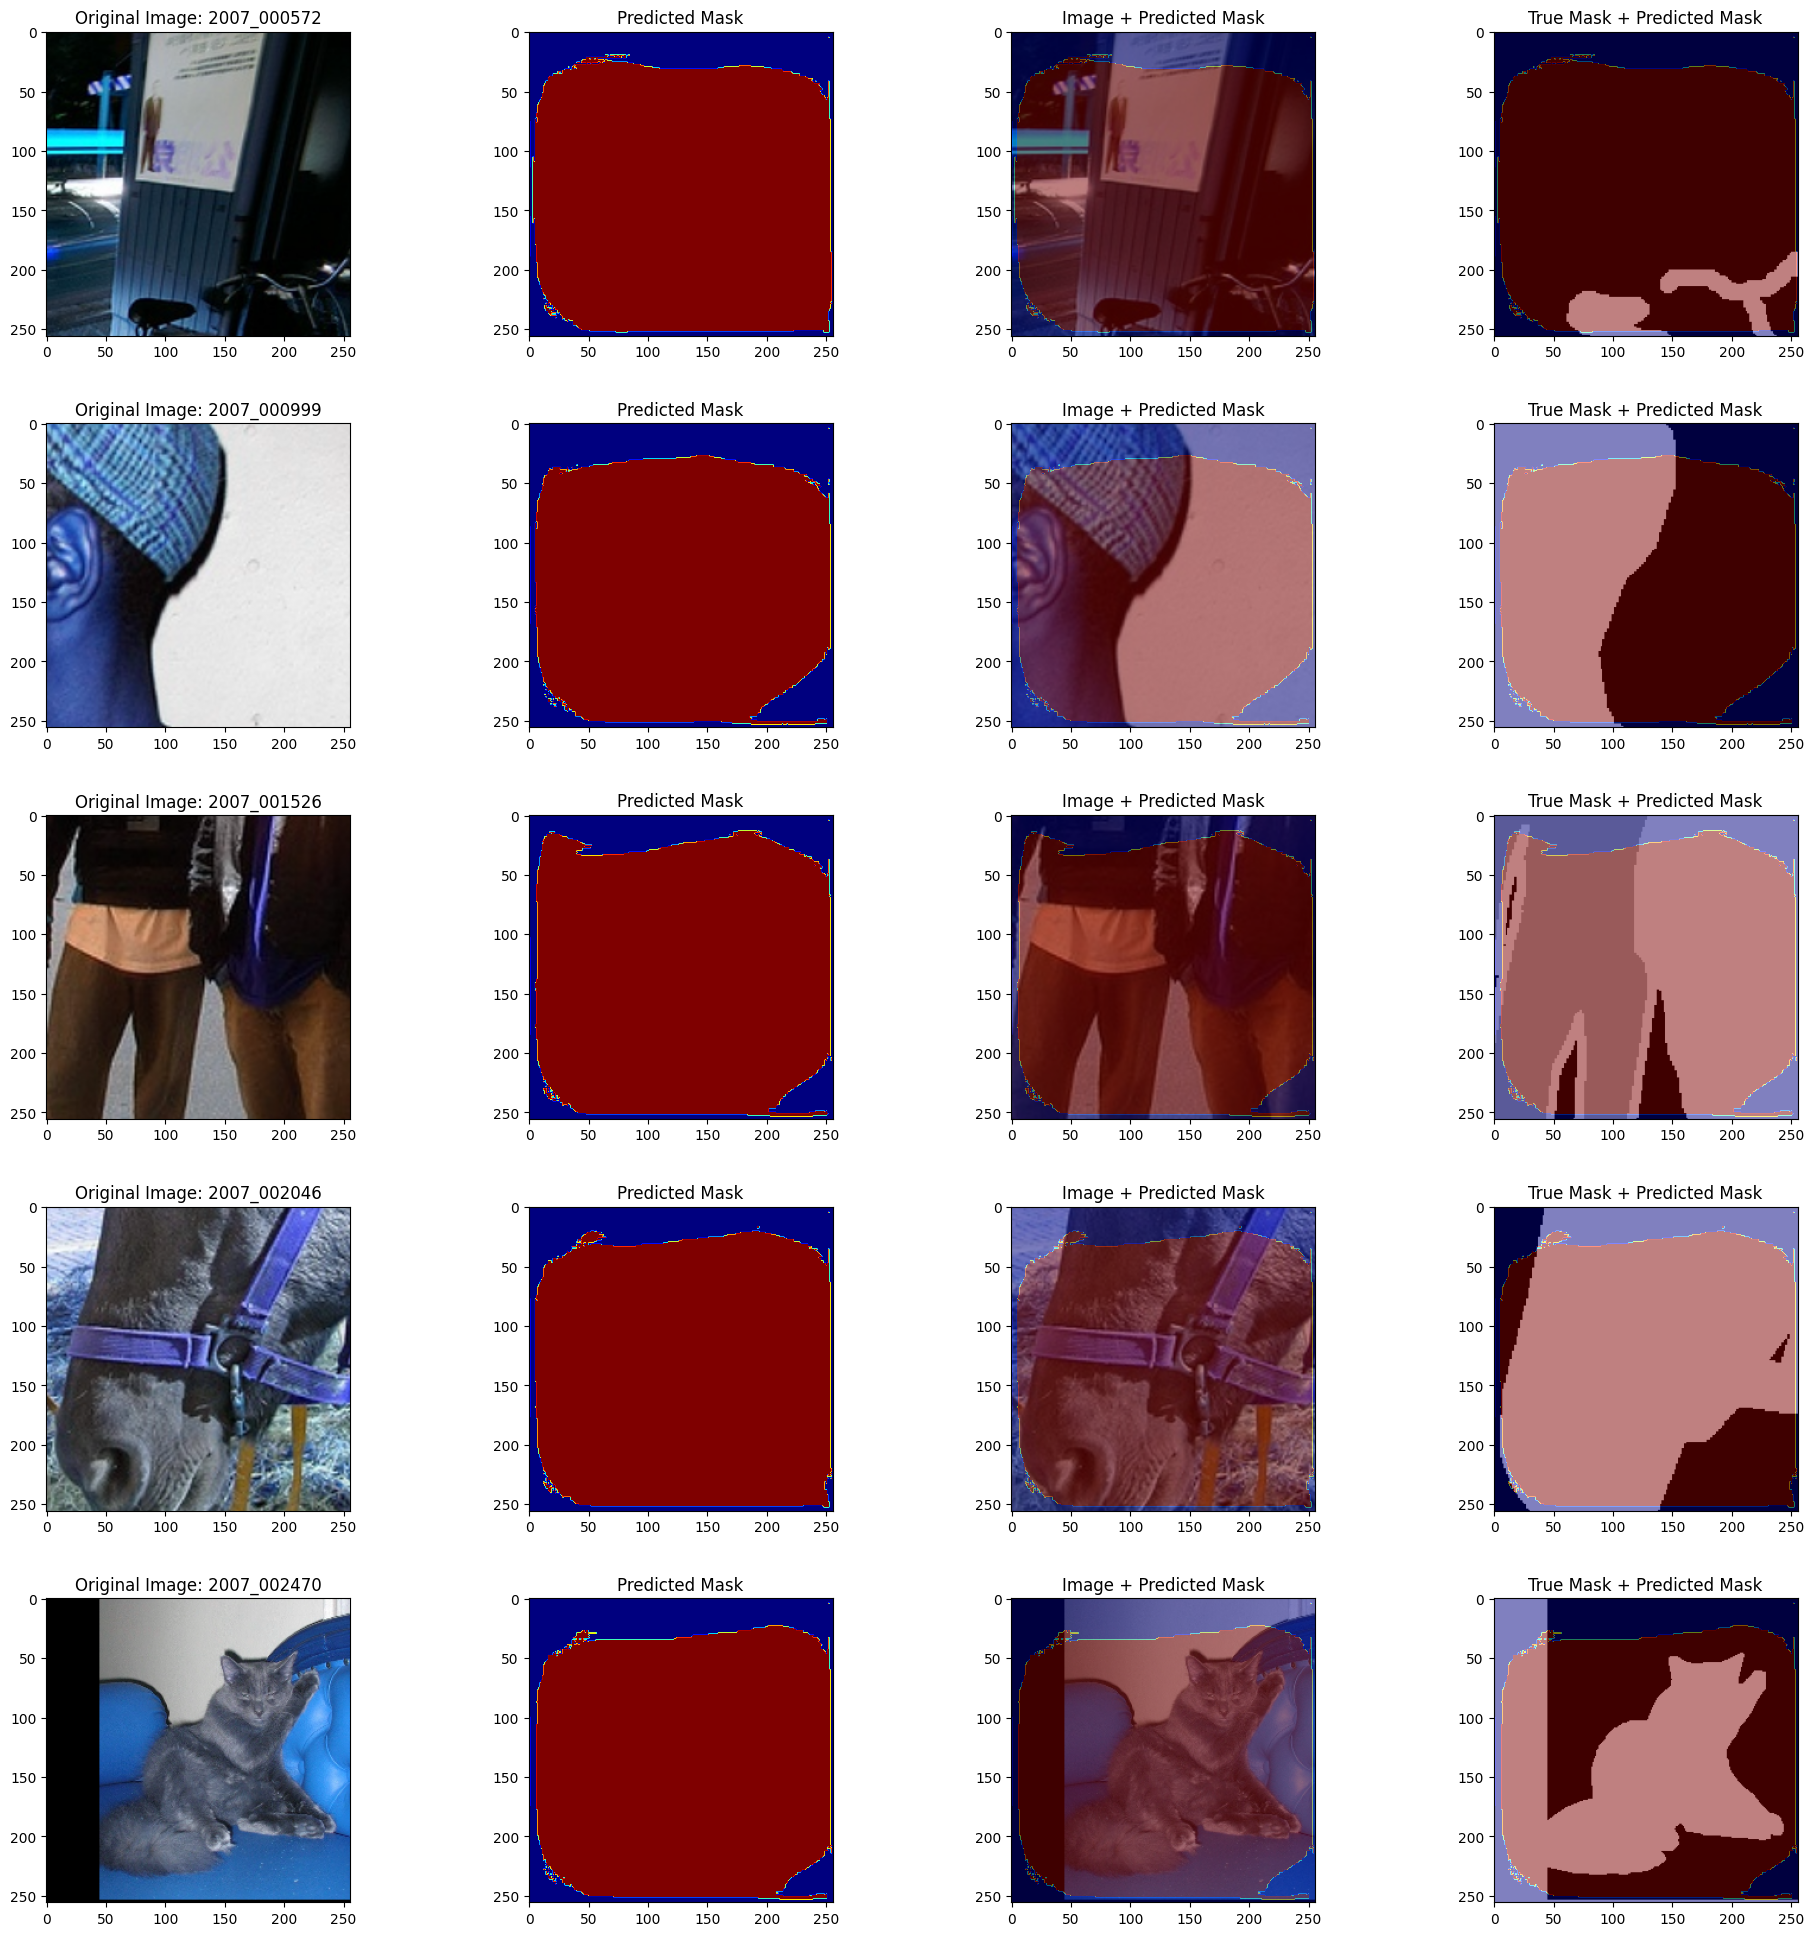

In [29]:
predict_and_visualize(unet_model,test_generator)


This model is a **complete and utter disappointment**. The custom layers and the different backbone definitely helped the **previous model perform better.**

-----------------------------------

Hence. the ***1st model with DenseNet121 is performing much better*** than an unaltered U-Net model.